# **Análise de Sentimento Usando o Dataset IMDB**

#### **Professores:** Roberto A. Lotufo e Rodrigo F. Nogueira
#### **Aluno:** Guilherme Rosa

#### **Modelo SentimentAnalyzer:**
- **Extrator de features: bloco-base do encoder do Transformer (multi-head self-attention + point-wise feed forward)**
- **Classificador: rede MLP com uma camada intermediária**

### **1. Imports**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import gensim
import gensim.downloader as api

import itertools
import collections
import re
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando: {device}')

Usando: cuda


### **2. Preparação dos dados**

#### **2.1. Download do dataset com amostras de treinamento e validação**

In [ ]:
!wget -nc http://files.fast.ai/data/aclImdb.tgz 
!tar -xzf aclImdb.tgz

File ‘aclImdb.tgz’ already there; not retrieving.



#### **2.2. Dados de treinamento e teste + construção das labels**

In [ ]:
def load_texts(folder):
    texts = []
    for path in os.listdir(folder):
        with open(os.path.join(folder, path)) as f:
            texts.append(f.read())
    return texts

x_train_pos = load_texts('aclImdb/train/pos')
x_train_neg = load_texts('aclImdb/train/neg')
x_test_pos = load_texts('aclImdb/test/pos')
x_test_neg = load_texts('aclImdb/test/neg')

x_train = x_train_pos + x_train_neg
x_test = x_test_pos + x_test_neg
y_train = [True] * len(x_train_pos) + [False] * len(x_train_neg)
y_test = [True] * len(x_test_pos) + [False] * len(x_test_neg)


print(len(x_train), 'amostras de treino.')
print(len(x_test), 'amostras de teste.')

25000 amostras de treino.
25000 amostras de teste.


#### **2.3. Separação das amostras em conjuntos de treinamento e validação**

In [ ]:
# Obs I: Os dados são convertidos para np.array para aplicação do train_test_split
# Obs II: Os dados são convertidos novamente para listas pois a função tokens_to_ids_batch() recebe listas de frases como entradas
X_train, X_valid, Y_train, Y_valid = train_test_split(np.array(x_train), np.array(y_train), test_size=0.2, random_state=42)

X_train = list(X_train)
X_valid = list(X_valid)
Y_train = list(Y_train)
Y_valid = list(Y_valid)

print(len(X_train), len(X_valid), len(Y_train), len(Y_valid))

20000 5000 20000 5000


### **3. Word embeddings e vocabulário**

#### **3.1. Download do word embedding**

Lista dos modelos disponíveis: https://github.com/RaRe-Technologies/gensim-data#models

In [ ]:
glove_model = api.load("glove-wiki-gigaword-300")

print(glove_model.vectors.shape)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(400000, 300)


#### **3.2. Criando o vocabulário**

O vocabulário vai conter as 400000 palavras nas quais o word2vec foi desenvolvido.

Além disso, incluímos um PAD token [PAD] para preencher com id = 400000 as sequências que possuem um número de tokens menor do que o número de tokens nos quais as sequências são truncadas.


In [ ]:
vocab = {word: index for index, word in enumerate(glove_model.index2word)}
vocab['[PAD]'] = len(vocab)

print('Número de palavras no vocabulário:', len(vocab))
print(f'20 tokens mais frequentes: {list(itertools.islice(vocab.keys(), 20))}')

Número de palavras no vocabulário: 400001
20 tokens mais frequentes: ['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as']


#### **3.3. Alterando a matriz do word2vec**
Na definição da rede neural (seção 5.1) utilizaremos a camada de Embedding do Pytorch.

Para que essa camada funcione corretamente é necessário que a matriz de embedding do word2vec tenha uma linha correspondente ao id do PAD token.

In [ ]:
embedding_pad = np.zeros(shape=(1, glove_model.vectors.shape[1]))
glove_vectors = np.append(glove_model.vectors, embedding_pad, axis=0)

print(glove_vectors.shape)

(400001, 300)


### **4. Funções de tokenização e truncamento**

#### **4.1. Funções de tokenização e de conversão para ids**

In [ ]:
def tokenize(text):
    """ Entrada: frase dada numa variável do tipo string
        -------
        Saída  : lista de tokens
    """
    # \w retorna todos os caracteres alfanuméricos e underscore
    # \w+ retorna todas as palavras que contém caracteres alfanuméricos e underscore 
    return re.findall(r'\w+', text.lower())

def tokens_to_ids(tokens, vocab):
    """ Entrada: lista de tokens e um dicionário com pares token: id
        -------
        Saída  : lista de ids
    """
    # Se o token não corresponde a nenhuma palavra do vocabulário, ele é desconsiderado.
    return [vocab[token] for token in tokens if token in vocab]

def tokens_to_ids_batch(texts, vocab):
    """ Entrada: lista de frases
        -------
        Saída  : lista de listas de ids (cada lista de ids corresponde a uma frase da listas de frase de entrada)
    """
    return [tokens_to_ids(tokenize(text), vocab) for text in texts]
        

X_train_ids = tokens_to_ids_batch(X_train, vocab)
X_valid_ids = tokens_to_ids_batch(X_valid, vocab)

print('Primeiro exemplo:')
print(X_train[0])
print(X_train_ids[0])
print(f'Número de tokens da sequência: {len(X_train_ids[0])}')
print(Y_train[0])
print('len(X_train_ids)', len(X_train_ids))
print('len(X_valid_ids)', len(X_valid_ids))

Primeiro exemplo:
I guess I have still enough brain left to NOT find this movie funny. -Great comedians - but a very poor movie! The "best" performance still did NINA HAGEN <br /><br />TRIVIA: Did you realize that it the "real world" scenes (in Hamburg) the cars are almost ONLY new BMWs ?? <br /><br />I guess I have still enough brain left to NOT find this movie funny. -Great comedians - but a very poor movie! The "best" performance still did NINA HAGEN <br /><br />TRIVIA: Did you realize that it the "real world" scenes (in Hamburg) the cars are almost ONLY new BMWs ??
[41, 5020, 41, 33, 149, 575, 2955, 218, 4, 36, 596, 37, 1005, 5466, 353, 21306, 34, 7, 191, 992, 1005, 0, 254, 883, 149, 119, 13196, 25537, 30410, 30410, 18285, 119, 81, 4223, 12, 20, 0, 567, 85, 3468, 6, 6888, 0, 1277, 32, 591, 91, 50, 60912, 30410, 30410, 41, 5020, 41, 33, 149, 575, 2955, 218, 4, 36, 596, 37, 1005, 5466, 353, 21306, 34, 7, 191, 992, 1005, 0, 254, 883, 149, 119, 13196, 25537, 30410, 30410, 18285, 119, 8

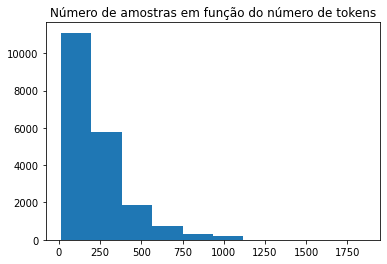

In [ ]:
num_tokens = [len(X_train_id) for X_train_id in X_train_ids]
_ = plt.hist(num_tokens)
plt.title('Número de amostras em função do número de tokens');

#### **4.2. Função para truncamento e padding**

In [ ]:
def truncate_and_pad(batch_word_ids, 
                     pad_token_id=400000, 
                     seq_length=64):
    """ Padroniza as listas de ids do batch de entrada para que todas tenham o mesmo número de elementos (seq_length).
        
        Entrada: listas de listas de ids
        -------
        Saídas : numpy arrays dos ids e das masks 
    """
    # Parte 1: Se o nº de ids > seq_length -> retorna os primeiros seq_length ids (os demais são descartados)
    #          Se o nº de ids < seq_length -> não modifica a lista de ids
    batch_word_ids = [word_ids[:seq_length] if len(word_ids) > seq_length else word_ids for word_ids in batch_word_ids]
    
    # Parte 2: Se o nº de ids > seq_length -> não modifica a lista de ids
    #          Se o nº de ids < seq_length -> cria uma lista com o número de PAD ids necessários para completar o tamanho da lista
    #                                         e concatena ela ao final da lista de ids
    batch_word_ids = [word_ids + [pad_token_id for i in range(seq_length - len(word_ids))] if len(word_ids) < seq_length else word_ids for word_ids in batch_word_ids]
    batch_word_ids = np.array(batch_word_ids)
    
    # Parte 3: Cria a mask utilizada na função softmax
    mask = batch_word_ids != pad_token_id

    return batch_word_ids, mask

# Testing
texts = ['we like pizza', 'he does not like apples']
batch_word_ids = tokens_to_ids_batch(texts, 
                                     vocab)
print(batch_word_ids)
batch, mask = truncate_and_pad(batch_word_ids=batch_word_ids, 
                               pad_token_id=vocab['[PAD]'],
                               seq_length=8)

print('batch:\n', batch)
print('mask:\n', mask)
print('batch.shape:', batch.shape)
print('mask.shape:', mask.shape)

[[53, 117, 9388], [18, 260, 36, 117, 13134]]
batch:
 [[    53    117   9388 400000 400000 400000 400000 400000]
 [    18    260     36    117  13134 400000 400000 400000]]
mask:
 [[ True  True  True False False False False False]
 [ True  True  True  True  True False False False]]
batch.shape: (2, 8)
mask.shape: (2, 8)


### **5. Definição da rede neural com self-attention**



#### **5.1. Positional Encoding**

In [ ]:
class PositionalEncoding(nn.Module):
    """ Soma a matriz de embeddings de uma sequência de entrada com a matriz de positional embeddings.
        Matriz de positional embeddings -> possui parâmetros treináveis. Cada linha corresponde a uma posição da sequência.
        -----------
        Sequência de entrada shape = (L, D) -> L embeddings de dimensão (1, D)
        Matriz P_encoding    shape = (L, D) -> L embeddings de posição  (1, D)

    """
    def __init__(self, D, L):
        super(PositionalEncoding, self).__init__()
        self.L, self.D = L, D
        self.positional_encoding = nn.Linear(self.L, self.D, bias=False)
    
    def forward(self, x):                                                   # x.shape = (B, L, D)
        P_encoding = torch.transpose(self.positional_encoding.weight, 1, 0) # P_encoding.shape = (L, D)
        x = x + P_encoding.unsqueeze(0)                                     # x.shape = (B, L, D) + (1, L, D) = (B, L, D)
        return x

#### **5.2. Scaled Dot Self-Attention**

In [ ]:
class ScaledDotSelfAttention(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.sqrtD = torch.sqrt(torch.tensor(D).float())
    
    def forward(self, Q, K, V, mask):  # Q, K, V.shape = (B, H, L, D/H)    mask.shape = (B, L)
        scores = torch.matmul(Q, torch.transpose(K, -1, -2))  # scores.shape = (B, H, L, D/H) x (B, H, D/H, L) = (B, H, L, L)
        scores = scores / self.sqrtD                         
        mask = mask.unsqueeze(dim=1).unsqueeze(dim=1)         # mask.shape = (B, 1, 1, L)
        scores = scores.masked_fill(mask == False, -1e9)
        probs = torch.softmax(scores, dim=-1)                 # probs.shape = (B, H, L, L)
        x = torch.matmul(probs, V)                            # x.shape = (B, H, L, L) x (B, H, L, D/H) = (B, H, L, D/H)
        return x

#### **5.3. Multi-Head Self-Attention**

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, D, L, H):
        super().__init__()
        self.D, self.L, self.H = D, L, H
        self.W_q = nn.Linear(self.D, self.D, bias=False) 
        self.W_k = nn.Linear(self.D, self.D, bias=False) 
        self.W_v = nn.Linear(self.D, self.D, bias=False) 
        self.W_o = nn.Linear(self.D, self.D, bias=False)
        self.self_attention = ScaledDotSelfAttention(self.D)

    def forward(self, x, mask):  # x.shape = (B, L, D)    mask.shape = (B, L)
        Q = self.W_q(x).reshape(x.shape[0], self.L, self.H, int(self.D/self.H))  # Q.shape = (B, L, H, D/H)
        K = self.W_k(x).reshape(x.shape[0], self.L, self.H, int(self.D/self.H))  # K.shape = (B, L, H, D/H)
        V = self.W_v(x).reshape(x.shape[0], self.L, self.H, int(self.D/self.H))  # V.shape = (B, L, H, D/H)
        Q, K, V = Q.transpose(1, 2), K.transpose(1, 2), V.transpose(1, 2)        # Q, K, V.shape = (B, H, L, D/H) -> Permite que o self-attention seja feito em paralelo para cada head
        x = self.self_attention(Q, K, V, mask)                                   # x.shape = (B, H, L, D/H)
        x = x.transpose(1, 2).contiguous()                                       # x.shape = (B, L, H, D/H)
        x = x.reshape(x.shape[0], self.L, self.D)                                # x.shape = (B, L, D)
        x = self.W_o(x)                                                          # x.shape = (B, L, D)
        return x

#### **5.4. Residual Connection, Add & LayerNorm**

In [ ]:
class ResConnectionLayerNorm(nn.Module):
    """ Realiza duas operações:
          - Soma as informações que percorrem o shortcut (residual) e o deep path (x)
          - Aplica uma camada de Layer Normalization com parâmetros a serem aprendidos. 
    """
    def __init__(self, D):
        super().__init__()
        self.D = D
        self.layer_norm = nn.LayerNorm(self.D)

    def forward(self, residual, x):          # residual.shape = (B, L, D)      x.shape = (B, L, D)
        x = self.layer_norm(residual + x)    # x.shape = (B, L, D)
        return x

#### **5.5. Point-Wise Feed Forward**

In [ ]:
class PointWiseFeedForward(nn.Module):
    def __init__(self, D):
        super().__init__()
        self.D = D
        self.FFlinear1 = nn.Linear(self.D, 2048) # (D, 2048) -> broadcasting (1, 1, D, 2048)
        self.FFlinear2 = nn.Linear(2048, self.D) # (2048, D) -> broadcasting (1, 1, 2048, D)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.3)

    def forward(self, x):  # x.shape = (B, L, D)
        x = F.relu(self.dropout1(self.FFlinear1(x)))  # x.shape = (B, L, 2048)
        x = self.dropout2(self.FFlinear2(x))          # x.shape = (B, L, D)
        return x

#### **5.6. Encoder do Transformer**

In [ ]:
class Encoder(nn.Module):
    def __init__(self, embeddings, pad_token_id, L, H):
        super().__init__()

        self.glove_matrix = embeddings       
        self.D, self.L, self.H = self.glove_matrix.shape[1], L, H
        self.pad_token_id = pad_token_id              
        
        self.word_embedding = nn.Embedding.from_pretrained(torch.from_numpy(self.glove_matrix), freeze=True, padding_idx=self.pad_token_id)
        self.positional_encoding = PositionalEncoding(self.D, self.L)
        self.multihead_selfattention = MultiHeadSelfAttention(self.D, self.L, self.H)
        self.resconnect_layernorm1 = ResConnectionLayerNorm(self.D)
        self.pointwise_feedforward = PointWiseFeedForward(self.D)
        self.resconnect_layernorm2 = ResConnectionLayerNorm(self.D)

    def forward(self, word_ids, mask):
        X_emb = self.word_embedding(word_ids).float()   # Faz word embedding                        
        X_emb = self.positional_encoding(X_emb)         # Adiciona informação de posição da sequência aos embeddings de entrada
        X = self.multihead_selfattention(X_emb, mask)   # Calcula as novas representações dos embeddings de entrada
        X_emb = self.resconnect_layernorm1(X_emb, X)    # Aplica LayerNorm à soma dos embeddings de entrada e saída da camada de atenção 
        X = self.pointwise_feedforward(X_emb)           # Aplica a camada feed forward individualmente a todos os embeddings
        X_emb = self.resconnect_layernorm2(X_emb, X)    # Aplica LayerNorm à soma dos embeddings de entrada e saída da camada feed-forward
        return X_emb


#### **5.7. Classificador Binário**

In [ ]:
class BinaryClassifier(nn.Module):
    def __init__(self, D, hidden_dim):
        super().__init__()
        self.D = D
        self.hidden_dim = hidden_dim
        self.linear = nn.Linear(self.D, self.hidden_dim)
        self.output = nn.Linear(self.hidden_dim, 2)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):                          # x.shape = (B, D)
        x = F.relu(self.dropout(self.linear(x)))   # x.shape = (B, hidden_dim)
        logits = self.output(x)                    # logits.shape = (B, 2)
        return logits

#### **5.8. Sentiment Analyzer**

In [ ]:
class SentimentAnalyzer(nn.Module):
    def __init__(self, embeddings, hidden_dim, pad_token_id, L, H):
        super().__init__()
        
        self.glove_matrix = embeddings       
        self.D, self.L, self.H = self.glove_matrix.shape[1], L, H
        self.hidden_dim = hidden_dim            
        self.pad_token_id = pad_token_id         

        self.encoder = Encoder(self.glove_matrix, self.pad_token_id, self.L, self.H)
        self.classifier = BinaryClassifier(self.D, self.hidden_dim)  
    
    def forward(self, word_ids, mask):
        x = self.encoder(word_ids, mask)                                                   # x.shape = (B, L, D)
        x = (x * mask.unsqueeze(2)).sum(1) / torch.clamp(mask.sum(1), min=1).unsqueeze(1)  # x.shape = (B, D)
        logits = self.classifier(x)                                                        # logits.shape = (B, 2)
        return logits

#### **5.9. Verificando o funcionamento do SentimentAnalyzer**

In [ ]:
texts = ['we like pizza', 'he does not like apples', 'i need to sleep now because i am tired']
SEQ_LENGTH = 8
batch_word_ids = tokens_to_ids_batch(texts, 
                                     vocab)
batch, mask = truncate_and_pad(batch_word_ids=batch_word_ids, 
                               pad_token_id=vocab['[PAD]'],
                               seq_length=SEQ_LENGTH)

model = SentimentAnalyzer(embeddings=glove_vectors, hidden_dim=300, pad_token_id=vocab['[PAD]'], L=SEQ_LENGTH, H=4).to(device)
seqs_ids = torch.from_numpy(batch)
mask = torch.from_numpy(mask)

out = model(seqs_ids.to(device), mask.to(device))
print(out.shape)

torch.Size([3, 2])


### **6. Funções auxiliares**


#### **6.1. Função para retornar mini-batch**

Durante o treinamento de uma rede neural, ao ínves de ajustarmos seus pesos usando todo o dataset de treinamento de uma só vez, é comum usarmos mini-batches, que são apenas algums exemplos amostrados do conjunto de dados. Repetimos isso diversas vezes até termos usado todo o conjunto de treinamento.

Para isso precisamos criar uma função que retorna mini-batches. A função abaixo retorna uma lista de listas contento os índices dos exemplos que serão usados em cada mini-batch. Por exemplo, se o dataset contém 6 amostras e o batch size é 2, a função retorna uma lista contendo 3 listas, cada uma contendo 2 índices: `[[4, 2], [3, 5], [0, 1]]`


In [ ]:
def get_minibatches_idx(total_size, batch_size, shuffle):
    idx_list = np.arange(total_size, dtype=np.int32)
    if shuffle:
        np.random.shuffle(idx_list)

    minibatches = []
    minibatch_start = 0
    for i in range(len(idx_list) // batch_size):
        minibatches.append(idx_list[minibatch_start:
                                    minibatch_start + batch_size])
        minibatch_start += batch_size

    if (minibatch_start != len(idx_list)):
        # Fazemos um minibatch do que restou.
        minibatches.append(idx_list[minibatch_start:])

    return minibatches

#### **6.2. Função de treinamento**

In [ ]:
@torch.enable_grad()
def train(X, Y, model, optimizer, criterion, seqlen):
    minibatches = get_minibatches_idx(total_size=len(X), batch_size=16, shuffle=True)

    running_loss = 0
    running_score = 0
    model.train()
    for minibatch_idxs in minibatches:
        # Retorna as listas de índices e os respectivos targets para o mini-batch:
        X_batch = [X[minibatch_idx] for minibatch_idx in minibatch_idxs]
        Y_batch = Y[minibatch_idxs]

        # Faz a padronização do tamanho das sequências de entrada do modelo:
        X_batch, mask = truncate_and_pad(X_batch, seq_length=seqlen, pad_token_id=vocab['[PAD]'])
        
        # Conversão para tensores:
        X_batch = torch.from_numpy(np.array(X_batch, dtype=np.int64)).to(device)
        mask = torch.from_numpy(np.array(mask)).to(device)
        Y_batch = torch.from_numpy(Y_batch).to(device)

        logits = model(word_ids=X_batch, mask=mask)   # Etapa forward
        loss = criterion(logits, Y_batch)             # Cálculo da função custo
        running_loss += loss                          # Custo acumulado
        optimizer.zero_grad()
        loss.backward()                               # Etapa backward (cálculo do gradiente)
        optimizer.step()                              # Ajuste dos pesos sinápticos do modelo e parâmetros do otimizador
        
        class_predictons = logits.argmax(dim=1)                # Predições do modelo para as amostras do mini-batch
        running_score += (class_predictons == Y_batch).sum()   # Soma o número de predições corretas para o mini-batch

    epoch_loss = running_loss.item() / len(minibatches)      # Custo médio da época
    epoch_score = running_score.item() / len(X)              # Número de acertos da época
    return epoch_loss,epoch_score

#### **6.3. Função de validação**

In [ ]:
@torch.no_grad()
def evaluate(X, Y, model, criterion, seqlen):
    minibatches = get_minibatches_idx(total_size=len(X), batch_size=32, shuffle=False)
    
    running_loss = 0
    running_score = 0
    model.eval()
    for minibatch_idxs in minibatches:
        # Retorna as listas de índices e os respectivos targets para o mini-batch:
        X_batch = [X[minibatch_idx] for minibatch_idx in minibatch_idxs]
        Y_batch = Y[minibatch_idxs]

        # Faz a padronização do tamanho das sequências de entrada do modelo:
        X_batch, mask = truncate_and_pad(X_batch, seq_length=seqlen, pad_token_id=vocab['[PAD]'])

        # Conversão para tensores:
        X_batch = torch.from_numpy(np.array(X_batch, dtype=np.int64)).to(device)
        mask = torch.from_numpy(np.array(mask)).to(device)
        Y_batch = torch.from_numpy(Y_batch).to(device)

        logits = model(word_ids=X_batch, mask=mask)            # Etapa forward
        loss = criterion(logits, Y_batch)                      # Cálculo da função custo
        running_loss += loss                                   # Custo acumulado
        
        class_predictons = logits.argmax(dim=1)                # Predições do modelo para as amostras do mini-batch
        running_score += (class_predictons == Y_batch).sum()   # Soma o número de predições corretas para o mini-batch

    epoch_loss = running_loss.item() / len(minibatches)         # Custo médio da época
    epoch_score = running_score.item() / len(X)                 # Número de acertos da época
    return epoch_loss, epoch_score

#### **6.4. Função para plotar o gráficos da função custo**

In [ ]:
def plot_metrics(train_metric, val_metric, metric_name, num):
    plt.figure(num)
    plt.plot(train_metric, label='Training '+ metric_name)
    plt.plot(val_metric, label='Validation ' + metric_name)
    plt.title(metric_name.title() + ' vs Epochs')
    plt.legend(frameon=False)

    return

### **7. Treinamento do modelo**

In [ ]:
N_EPOCHS = 25
HEAD = 4
SEQLEN = 150

model = SentimentAnalyzer(embeddings=glove_vectors, hidden_dim=300, pad_token_id=vocab['[PAD]'], L=SEQLEN, H=HEAD).to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

X_train_ids = tokens_to_ids_batch(X_train, vocab)
X_valid_ids = tokens_to_ids_batch(X_valid, vocab)

if not isinstance(Y_train, np.ndarray):
    Y_train = np.array(Y_train).astype(np.int64)
    Y_valid = np.array(Y_valid).astype(np.int64)

train_losses = []
valid_losses = []
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(X=X_train_ids, Y=Y_train, model=model, optimizer=optimizer, criterion=criterion, seqlen=SEQLEN)
    valid_loss, valid_acc = evaluate(X=X_valid_ids, Y=Y_valid, model=model, criterion=criterion, seqlen=SEQLEN)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'epoch: {epoch} '
          f'Train loss: {train_loss:.3f} '
          f'Train accuracy: {train_acc:.3f} '
          f'Valid loss: {valid_loss:.3f} '
          f'Valid accuracy: {valid_acc:.3f}')

epoch: 0 Train loss: 0.632 Train accuracy: 0.638 Valid loss: 0.532 Valid accuracy: 0.753
epoch: 1 Train loss: 0.542 Train accuracy: 0.725 Valid loss: 0.496 Valid accuracy: 0.757
epoch: 2 Train loss: 0.504 Train accuracy: 0.753 Valid loss: 0.451 Valid accuracy: 0.788
epoch: 3 Train loss: 0.482 Train accuracy: 0.770 Valid loss: 0.490 Valid accuracy: 0.753
epoch: 4 Train loss: 0.469 Train accuracy: 0.779 Valid loss: 0.581 Valid accuracy: 0.706
epoch: 5 Train loss: 0.461 Train accuracy: 0.778 Valid loss: 0.458 Valid accuracy: 0.790
epoch: 6 Train loss: 0.451 Train accuracy: 0.789 Valid loss: 0.425 Valid accuracy: 0.805
epoch: 7 Train loss: 0.446 Train accuracy: 0.791 Valid loss: 0.422 Valid accuracy: 0.810
epoch: 8 Train loss: 0.443 Train accuracy: 0.793 Valid loss: 0.443 Valid accuracy: 0.787
epoch: 9 Train loss: 0.438 Train accuracy: 0.797 Valid loss: 0.417 Valid accuracy: 0.814
epoch: 10 Train loss: 0.431 Train accuracy: 0.799 Valid loss: 0.428 Valid accuracy: 0.805
epoch: 11 Train loss

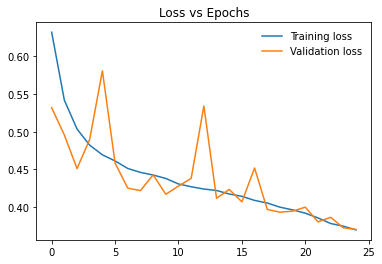

In [ ]:
plot_metrics(train_losses, valid_losses, 'loss', 1)

### **8. Métricas pedidas no exercício:**

#### **8.1. Tempo de execução de 1 laço de treinamento e o tempo médio por amostra:**

In [ ]:
model_time = SentimentAnalyzer(embeddings=glove_vectors, hidden_dim=300, pad_token_id=vocab['[PAD]'], L=SEQLEN, H=HEAD).to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

start_time = time.time()
train_loss, train_acc = train(X=X_train_ids, Y=Y_train, model=model_time, optimizer=optimizer, criterion=criterion, seqlen=SEQLEN)
end_time = time.time()
loop_time = end_time - start_time

print(f'Tempo de execução de 1 laço de treinamento: {loop_time} s.')
print(f'Tempo médio para processar 1 amostra: {loop_time*1000/len(X_train_ids)} ms.')

Tempo de execução de 1 laço de treinamento: 29.784704208374023 s.
Tempo médio para processar 1 amostra: 1.4892352104187012 ms.


#### **8.2. Acurácia junto aos dados de teste:**

In [ ]:
X_test_ids = tokens_to_ids_batch(x_test, vocab)

if not isinstance(y_test, np.ndarray):
    Y_test = np.array(y_test).astype(np.int64)

test_loss, test_acc = evaluate(X=X_test_ids, Y=Y_test, model=model, criterion=criterion, seqlen=150)
print(f'Acurácia no teste: {test_acc*100}%')

Acurácia no teste: 83.26%


#### **8.3. Número de parâmetros ajustáveis do modelo:**

In [ ]:
L = 150
D = 300

positional_encoding = L*D
multi_head = 4*D*D
layernorm1 = 2*D
pointwise_feedforward = (D*2048 + 2048) + (2048*D + D)
layernorm2 = 2*D
classifier = (D*300 + 300) + (300*2 + 2)

param = positional_encoding + multi_head + layernorm1 + pointwise_feedforward + layernorm2 + classifier
print(param)

1728250


In [ ]:
num_params = [params.numel() for params in list(model.parameters())]
print(f'Número de parâmetros totais (incluindo os não treináveis do glove: {num_params}')
num_params = np.sum(np.array(num_params[1::]))
print(f'Número de parâmetros treináveis do modelo: {num_params}')

Número de parâmetros totais (incluindo os não treináveis do glove: [120000300, 45000, 90000, 90000, 90000, 90000, 300, 300, 614400, 2048, 614400, 300, 300, 300, 90000, 300, 600, 2]
Número de parâmetros treináveis do modelo: 1728250


#### **8.4. Alguns hiperparâmetros:**

In [ ]:
print(f'Número de palavras por amostra: {SEQLEN}')
print(f'Embedding size: {glove_model.vector_size}')
print(f'Batch size de treinamento: 16')

Número de palavras por amostra: 150
Embedding size: 300
Batch size de treinamento: 16
